# CNN layers visualization

In this notebook, I want to figure out how CNN sees things. By getting one activation map and try maximizing it. We can get a sense of what the corresponding filter wants to get. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

# Load the model
I'm using VGG16 CNN architecture with imagenet weights for visualization. VGG16 has 16 layers in total, 13 Convnet and 3 Fully Connected, and accepts 224x224 RGB image as input.

In [3]:
vgg = models.vgg16(pretrained=True)
# Print out the structure
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
# From output of the cell above. I define a dictionary maps layer index and number of filters in that layer to layer name
layer_dict = {'conv1_1': (0, 64), 'conv1_2': (2, 64), 'conv2_1': (5, 128), 'conv2_2': (7, 128), 'conv3_1': (10, 256), 'conv3_2': (12, 256),
               'conv3_3': (14, 256), 'conv4_1': (17, 512), 'conv4_2': (19, 512), 'conv4_3': (21, 512), 'conv5_1': (24, 512),
               'conv5_2': (26, 512), 'conv5_3': (28, 512)}
layer_dict

{'conv1_1': (0, 64),
 'conv1_2': (2, 64),
 'conv2_1': (5, 128),
 'conv2_2': (7, 128),
 'conv3_1': (10, 256),
 'conv3_2': (12, 256),
 'conv3_3': (14, 256),
 'conv4_1': (17, 512),
 'conv4_2': (19, 512),
 'conv4_3': (21, 512),
 'conv5_1': (24, 512),
 'conv5_2': (26, 512),
 'conv5_3': (28, 512)}

Because I only need activation maps so I only get the `features` part. Also freeze the layers for faster computing.

In [5]:
vgg_f = vgg.features

# Turn off auto_grad for all layers
for param in vgg_f.parameters():
    param.requires_grad_(False)

Define a function which get an image and return the activation map at `layer_idx` position

In [6]:
def get_feature(image, model, layer_idx):
    x = image
    for i, layer in enumerate(model.children()):
        x = layer(x)
        if i == layer_idx:
            break
    return x

### Loss function
Define loss function we want to minimize. Here, the loss function is just the minus average of all units in activation map

In [9]:
def calc_loss(image, model, layer_idx, filter_index):
    output = get_feature(image, model, layer_idx)
    return -torch.mean(output.squeeze()[filter_index,:,:])

In [52]:
# img_convert for converting image from Pytorch's Tensor object to Numpy's ndarray, reshape the image and reverse the normalization 
def img_convert(img):
    num_img = img.to("cpu").clone().detach()
    # reshape from (channel, height, width) to (height, width, channel)
    num_img = num_img.numpy().squeeze().transpose(1,2,0) 
    # Reverse normalization
    num_img = num_img*np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    # clip pixel values from [0,1]
    num_img = num_img.clip(0,1)
    return num_img

## Training
It's time for the real business. In the cell below, you can specify number of time you want for minimizing loss (`epoch`), the layer you want to do it (`layer_name`) and the range of filters (`filter_from` and `filter_to`) you want to visualize. It will use gpu if available to train faster.

In [36]:
# Check if cuda is available to train on GPU
if torch.cuda.is_available():
    print("Using cuda!")
    print(torch.cuda.get_device_name(device))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### Do not modify anything above ###

epoch = 1000
layer_name = 'conv5_3'
filter_from, filter_to = 0, 20

### Do not modify anything below ###
results = [] 
layer_idx, total_filter = layer_dict[layer_name]

# Check if valid range
invalid = False
if filter_to > total_filter or filter_to <= filter_from:
    print("Invalid range")
    invalid = True

# At each filter, generate a random image of size (1, 3, 224, 224), corresponding to (batch size, channel, height, width), 
# and using backpropagation to determine how the picture should look
if not invalid:
    for fil in range(filter_from, filter_to):
        # Move model and image to GPU if available
        vgg_f = vgg_f.to(device)
        image = torch.rand((1,3,224,224), requires_grad = True, device = device)
        # Using Adam for optimizing
        optimizer = optim.Adam([image], lr=0.001)
        print(f"Generating for filter {fil}...")
        
        # Training loop
        for e in range(epoch):
            optimizer.zero_grad()
            loss = calc_loss(image, vgg_f, layer_idx, fil)
            loss.backward()
            optimizer.step()
        
        # convert image and store it in `results`
        cvr_img = img_convert(image)
        results.append((fil, cvr_img))

GeForce MX150
Filter 0
Filter 1
Filter 2
Filter 3
Filter 4
Filter 5
Filter 6
Filter 7
Filter 8
Filter 9
Filter 10
Filter 11
Filter 12
Filter 13
Filter 14
Filter 15
Filter 16
Filter 17
Filter 18
Filter 19


### Ploting the results
I'm using pyplot to plot all images we got after training. You should see something like this:
<div style="text-align: center">
    <img src="images/conv5_3.png"/>
</div>

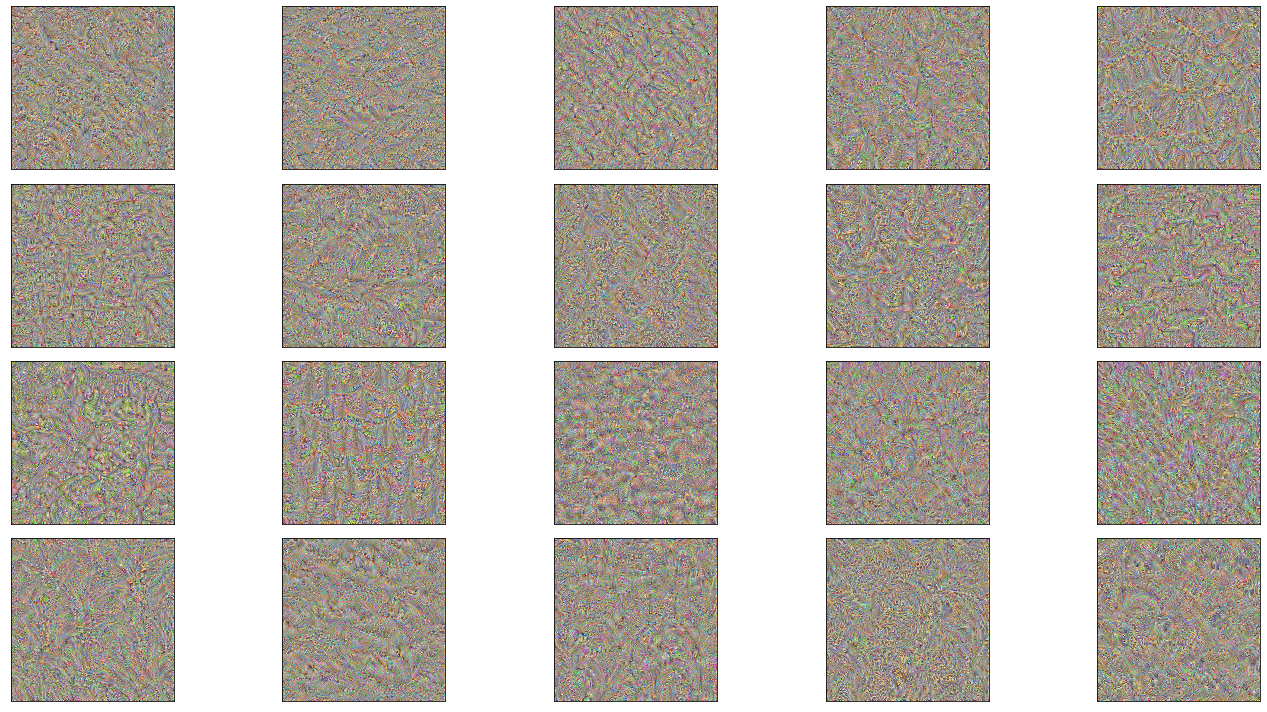

In [39]:
# Change this size if you want 
fig_size = (25, 10)

# Do not change any code below
fig = plt.figure(figsize=(20,10))
total_filter = filter_to - filter_from
row = math.ceil(total_filter/5)
for fil_idx, img in results:
    ax = fig.add_subplot(row, 5, fil_idx+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f'filter {fil_idx}')
plt.tight_layout()
plt.show()

# Bonus: Applying to picture to get cool effects
By doing the same for images. We can get super awesome effects

<div style="text-align:center"><img src="images/test.jpeg" /></div>
<div style="text-align:center">
    <img style="padding:1px" src="images/modified_test.jpg" /><img style="padding:1px" src="images/modified_test1.jpg" /></div>
</div>

### Load image

In [63]:
# Change the line below if you want to use yours. It's recommended that you use image with small size for faster result
img_dir = 'images/test.jpeg'

m_image = Image.open(img_dir).convert('RGB')
im_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])
m_image = im_transforms(m_image)[:3,:,:].unsqueeze(0)

In [64]:
# Check if shape correct
m_image.shape

torch.Size([1, 3, 333, 500])

## Applying effect
The same as the previous training loop. Defining number of epoch, layer_name, filter_idx you like. the image will have the same effect as the randomly generated one before.

In [68]:
# Check if cuda is available to train on GPU
if torch.cuda.is_available():
    print("Using cuda!")
    print(torch.cuda.get_device_name(device))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### Do not modify anything above ###

epoch = 1000
layer_name = 'conv4_3'
filter_idx = 10

### Do not modify anything below ###

layer_idx, total_filter = layer_dict[layer_name]
if filter_idx >= total_filter:
    filter_idx = total_filter - 1
    print("Invalid index. Using the last one")

vgg_f = vgg_f.to(device)
image = m_image.to(device).requires_grad_(True)
optimizer = optim.Adam([image], lr=0.001)
print(f"Using filter {fil}...")
for e in range(epoch):
    optimizer.zero_grad()
    loss = calc_loss(image, vgg_f, layer_idx, fil)
    loss.backward()
    optimizer.step()
cvr_img = no_resize_img_convert(image)

GeForce MX150
Filter 10


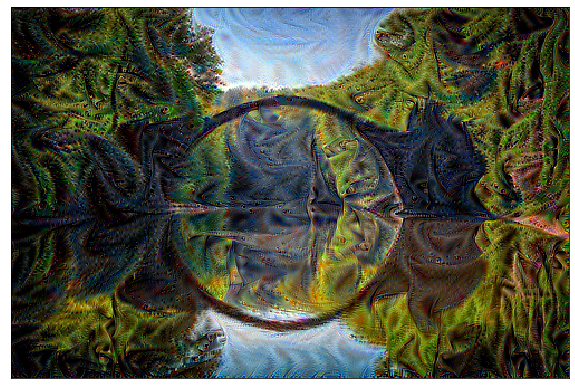

In [69]:
fig = plt.figure(figsize=(10,10))
img = cvr_img
ax = fig.add_subplot(1,1, 1, yticks=[], xticks=[])
ax.imshow(img)
plt.show()

## Saving result

In [70]:
name = 'temp.png' # Change the name if you like

plt.imsave(name, img)